# Imports

In [34]:
import os
import torch
import torch.nn as nn
import numpy as np
from IPython import embed
from skimage import color
from PIL import Image
from torch.utils.data import Dataset, IterableDataset
from torchsummary import summary
from tqdm.notebook import trange, tqdm
from torch.nn.utils.clip_grad import clip_grad_norm_
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import numpy as np
from skimage import color, io
import matplotlib.pyplot as plt
import torchvision.utils


In [2]:
# Hyper parameters and others
lr = 1e-3
epochs = 45
batch_size = 8
dp_save_path = "/content/dp.ckpt"
dp_save_path2 = "/content/dp2.ckpt"

# Data

In [3]:
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])
train_dataset = CIFAR10('./data/CIFAR10', train=True, transform=img_transform, target_transform=None, download=True)
test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



100%|██████████| 170498071/170498071 [00:14<00:00, 12027323.84it/s]


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


# Our Model

In [4]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) 
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) 
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) 
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) 
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1) 
        self.conv5_bn = nn.BatchNorm2d(256)
        # self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1) 
        # self.conv6_bn = nn.BatchNorm2d(256)
        # self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1) 
        # self.conv7_bn = nn.BatchNorm2d(256)

        self.rconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1) 
        self.rconv1_bn = nn.BatchNorm2d(128)
        self.rconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) 
        self.rconv2_bn = nn.BatchNorm2d(64)
        self.rconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) 
        self.rconv3_bn = nn.BatchNorm2d(32)
        self.rconv4 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1) 

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        # x = F.relu(self.conv6_bn(self.conv6(x)))
        # x = F.relu(self.conv7_bn(self.conv7(x)))

        x = F.relu(self.rconv1_bn(self.rconv1(x)))
        x = F.relu(self.rconv2_bn(self.rconv2(x)))
        x = F.relu(self.rconv3_bn(self.rconv3(x)))
        x = self.rconv4(x)

        return x

In [5]:
cmodel1 = ColorNet()
optimizer = torch.optim.Adam(params=cmodel1.parameters(), lr=lr)

In [12]:
def forward(x, model):
    res = model(x)
    return res 

def cal_loss(res, targets):
    loss = F.mse_loss(res, targets)
    return loss

def train_batch(batch, model):
    batch = batch[0]
    inputs, targets = batch[:, 0:1, :, :], batch[:, 1:3, :, :]
    res = forward(inputs, model)

    loss = cal_loss(res, targets)
    return loss


def training_step(batch, model):
    model.train()
    loss = train_batch(batch, model)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return abs(loss.item())

def val(batch, model):
    model.eval()
    batch = batch[0]
    inputs, targets = batch[:, 0:1, :, :], batch[:, 1:3, :, :]
    res = forward(inputs, model)
    loss = cal_loss(res, targets)
    return abs(loss.item())



if os.path.exists(dp_save_path):
  cmodel1.load_state_dict(torch.load(dp_save_path))

losses1 = []
losses1_val = []
# training loop
for epoch in range(0, epochs):
    pbar = None
    pbar = tqdm(train_dataloader, leave=True, total= len(train_dataloader))
    outputs = []
    vals = []

    for batch_nb, batch in enumerate(pbar):
        loss = training_step(batch, cmodel1)
        outputs.append(loss)
    
    pbar2 = tqdm(val_dataloader, leave=True, total= len(val_dataloader))

    for batch_nb, batch in enumerate(pbar2):
        loss = val(batch, cmodel1)
        vals.append(loss)
    

    train_result = np.mean(outputs)
    val_result = np.mean(vals)
    losses1.append(train_result)
    losses1_val.append(val_result)
    print('epoch = {}, train_loss = {} val_loass = {}'.format(epoch, train_result, val_result)) 
    print("saving checkpoint")
    torch.save(cmodel1.state_dict(), dp_save_path)

  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 0, train_loss = 157.7028367078993 val_loass = 153.7711040222168
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 1, train_loss = 154.95020238172742 val_loass = 149.99367307739257
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 2, train_loss = 151.34246839531792 val_loass = 149.45244503784178
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 3, train_loss = 147.85737802124024 val_loass = 150.07851748046875
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 4, train_loss = 143.92940856187607 val_loass = 154.56217853393554
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 5, train_loss = 139.30863216078018 val_loass = 168.26108104858397
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 6, train_loss = 134.52855489298503 val_loass = 155.46946006469727
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 7, train_loss = 129.3995885687934 val_loass = 153.9301070739746
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 8, train_loss = 123.49918958367242 val_loass = 155.1372773925781
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 9, train_loss = 117.79549967176649 val_loass = 158.6318505493164
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 10, train_loss = 112.25531911146376 val_loass = 164.62618216552735
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 11, train_loss = 107.34632537434896 val_loass = 172.21791231689454
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 12, train_loss = 102.85044661593967 val_loass = 161.18922762451172
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 13, train_loss = 98.81464499104818 val_loass = 161.81982545166017
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 14, train_loss = 95.25581079779731 val_loass = 165.50145759277345
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 15, train_loss = 92.121457679579 val_loass = 163.9860380004883
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 16, train_loss = 88.88825043029784 val_loass = 163.92378571166992
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 17, train_loss = 86.50254429423015 val_loass = 166.68677499389648
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 18, train_loss = 83.99313757052951 val_loass = 164.82584227294922
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 19, train_loss = 81.85184079962836 val_loass = 168.84405142822266
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 20, train_loss = 79.75674032965766 val_loass = 165.67258388061524
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 21, train_loss = 78.08448527323405 val_loass = 165.61076810913087
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 22, train_loss = 76.27751084187825 val_loass = 166.11810115966796
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 23, train_loss = 74.67722450324165 val_loass = 167.16976845703124
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 24, train_loss = 72.97846170416938 val_loass = 164.46777012939452
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 25, train_loss = 71.65013229370118 val_loass = 169.06552056884766
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 26, train_loss = 70.30999064602322 val_loass = 166.80721384887696
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 27, train_loss = 69.15888768378363 val_loass = 168.69505171508789
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 28, train_loss = 67.81048474561904 val_loass = 167.17089138793946
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 29, train_loss = 66.79543594360352 val_loass = 170.5482301147461
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 30, train_loss = 65.85592948710124 val_loass = 167.27571348876953
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 31, train_loss = 64.87355871446398 val_loass = 166.57539763793946
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 32, train_loss = 63.93537057596843 val_loass = 167.45275354003905
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 33, train_loss = 62.96949325052897 val_loass = 166.1014534362793
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 34, train_loss = 62.05591633572049 val_loass = 172.01564352416992
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 35, train_loss = 61.381153994750974 val_loass = 169.17313680419923
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 36, train_loss = 60.56675424296061 val_loass = 166.19570198974608
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 37, train_loss = 59.956244411892364 val_loass = 169.63985565795898
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 38, train_loss = 59.134268723890514 val_loass = 170.2220164855957
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 39, train_loss = 58.593596966891816 val_loass = 168.33479445800782
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 40, train_loss = 57.888019518703885 val_loass = 174.27835528564452
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 41, train_loss = 57.28874213562012 val_loass = 169.58808768310547
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 42, train_loss = 56.814939322916665 val_loass = 166.10005581054688
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 43, train_loss = 56.19469743889703 val_loass = 167.6718903991699
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 44, train_loss = 55.763409014553496 val_loass = 170.20779827880858
saving checkpoint


#Rebalance loss

In [24]:
def bmse_loss(inputs, targets):
    mse_loss = (inputs - targets) ** 2
    weights = torch.log(torch.abs(targets)+1)+1
    mse_loss = mse_loss*weights
    mse_loss = mse_loss.mean()/torch.sum(weights)
    return mse_loss

In [25]:
cmodel2 = ColorNet()
optimizer = torch.optim.Adam(params=cmodel2.parameters(), lr=lr)

In [27]:
def cal_loss(res, targets):
    loss = bmse_loss(res, targets)
    return loss


if os.path.exists(dp_save_path2):
  cmodel2.load_state_dict(torch.load(dp_save_path2))

losses2 = []
losses2_val = []
# training loop
for epoch in range(0, epochs):
    pbar = None
    pbar = tqdm(train_dataloader, leave=True, total= len(train_dataloader))
    outputs = []
    vals = []

    for batch_nb, batch in enumerate(pbar):
        loss = training_step(batch, cmodel2)
        outputs.append(loss)
    
    pbar2 = tqdm(val_dataloader, leave=True, total= len(val_dataloader))

    for batch_nb, batch in enumerate(pbar2):
        loss = val(batch, cmodel2)
        vals.append(loss)
    
    train_result = np.mean(outputs)
    losses2.append(train_result)
    val_result = np.mean(vals)
    losses2_val.append(val_result)
    print('epoch = {}, train_loss = {} val_loss = {}'.format(epoch, train_result, val_result)) 
    print("saving checkpoint")
    torch.save(cmodel2.state_dict(), dp_save_path2)

  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 0, train_loss = 0.01432007251187331 val_loss = 0.014704646533727645
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 1, train_loss = 0.014015240606665612 val_loss = 0.01377027399763465
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 2, train_loss = 0.013653785426831908 val_loss = 0.014167955823242664
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 3, train_loss = 0.013137328971508476 val_loss = 0.013434261186793446
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 4, train_loss = 0.012699356942499677 val_loss = 0.013117528279125691
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 5, train_loss = 0.012225812330759233 val_loss = 0.013038086528331041
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 6, train_loss = 0.011764793239823646 val_loss = 0.0129141721829772
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 7, train_loss = 0.011224148505760563 val_loss = 0.013253529303893447
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 8, train_loss = 0.01068070502926906 val_loss = 0.01577803783789277
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 9, train_loss = 0.010186264130059216 val_loss = 0.013664047005027533
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 10, train_loss = 0.00963967770424982 val_loss = 0.013562526173144579
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 11, train_loss = 0.009129137875719203 val_loss = 0.013903255603462457
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 12, train_loss = 0.00866597865505351 val_loss = 0.013910959097370505
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 13, train_loss = 0.00826461475868192 val_loss = 0.013931754814088345
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 14, train_loss = 0.007893223900927438 val_loss = 0.014271856742724777
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 15, train_loss = 0.007575977209541533 val_loss = 0.014128444170951843
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 16, train_loss = 0.007286274543694324 val_loss = 0.014255561120063067
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 17, train_loss = 0.007016660947766569 val_loss = 0.0143879854246974
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 18, train_loss = 0.006780200445941753 val_loss = 0.014253500053286553
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 19, train_loss = 0.006562594666745927 val_loss = 0.014388262755051255
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 20, train_loss = 0.006384574597494469 val_loss = 0.014311715053766966
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 21, train_loss = 0.006204323072669406 val_loss = 0.014452199629694223
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 22, train_loss = 0.006042944187670946 val_loss = 0.014471568679064512
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 23, train_loss = 0.005893006244177619 val_loss = 0.014915092568844556
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 24, train_loss = 0.005754835718580418 val_loss = 0.014609537924081087
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 25, train_loss = 0.00562478704382148 val_loss = 0.014552022793889046
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 26, train_loss = 0.005504526082012388 val_loss = 0.014636014833301306
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 27, train_loss = 0.005404869620460603 val_loss = 0.01443536927551031
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 28, train_loss = 0.005304294449877408 val_loss = 0.014508199294656516
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 29, train_loss = 0.0052069167898760906 val_loss = 0.014444527020305395
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 30, train_loss = 0.0051017922821351225 val_loss = 0.014402437386661767
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 31, train_loss = 0.005027997141083081 val_loss = 0.01447119884043932
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 32, train_loss = 0.0049476702327115665 val_loss = 0.01448463927283883
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 33, train_loss = 0.0048615581184004745 val_loss = 0.01441309366375208
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 34, train_loss = 0.004802044502397378 val_loss = 0.014511190897226333
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 35, train_loss = 0.004731634375887613 val_loss = 0.01465611862167716
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 36, train_loss = 0.004662367940238781 val_loss = 0.01473985296934843
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 37, train_loss = 0.0046180768575105405 val_loss = 0.014771421954035758
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 38, train_loss = 0.004540662777879172 val_loss = 0.01437664091438055
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 39, train_loss = 0.004494009803959893 val_loss = 0.014655103588104249
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 40, train_loss = 0.0044474460304404296 val_loss = 0.014716352934390307
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 41, train_loss = 0.004388463884861105 val_loss = 0.014675921685993671
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 42, train_loss = 0.004336374644107289 val_loss = 0.01483830034583807
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 43, train_loss = 0.004296839018911123 val_loss = 0.014406751064956189
saving checkpoint


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch = 44, train_loss = 0.004245245270948443 val_loss = 0.01456221142411232
saving checkpoint


#Result

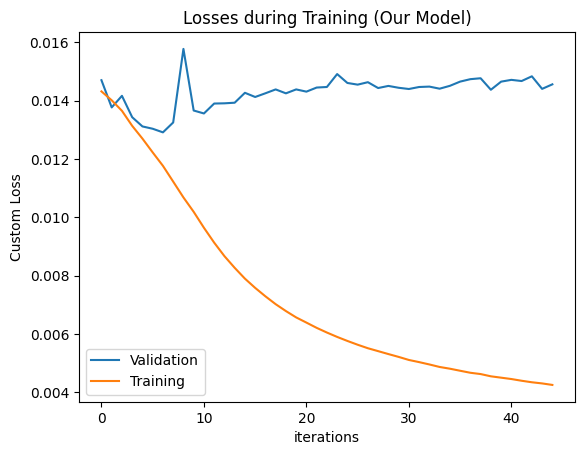

In [28]:
plt.plot(losses2_val, label = "Validation")
plt.plot(losses2, label = "Training")
plt.xlabel("iterations")
plt.ylabel("Custom Loss")
plt.title("Losses during Training (Our Model)")
plt.legend()
plt.show()

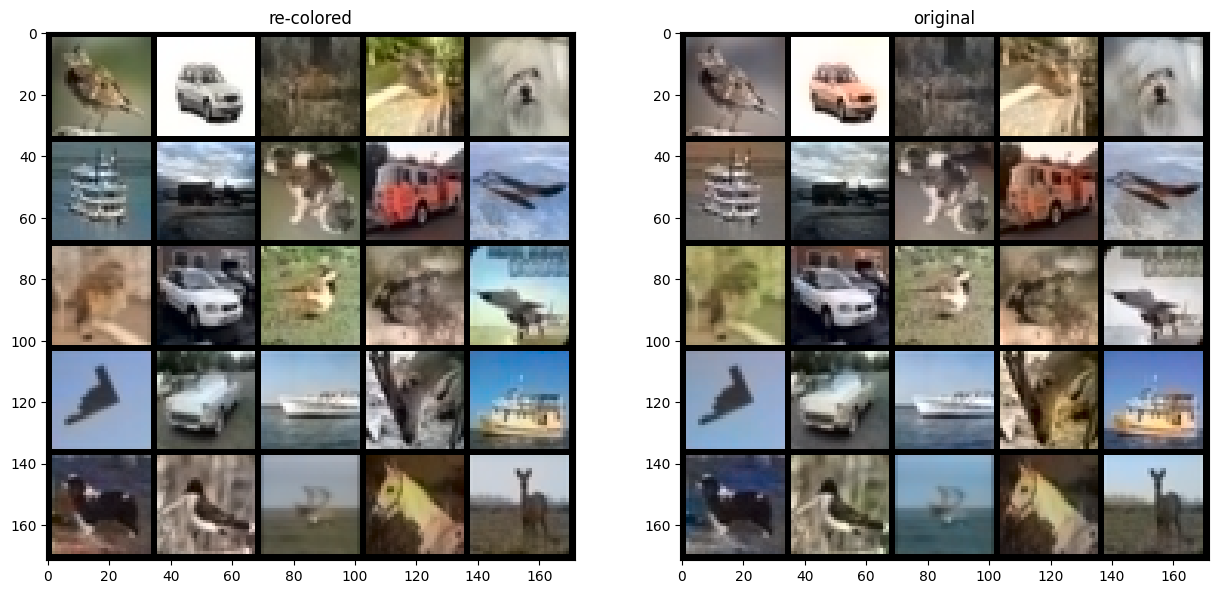

In [33]:
plt.ion()

with torch.no_grad():

    # pick a random subset of images from the test set
    image_inds = np.random.choice(len(test_dataset), 25, replace=False)
    lab_batch = torch.stack([test_dataset[i][0] for i in image_inds])
    # lab_batch = lab_batch.to(device)

    # predict colors (ab channels)
    predicted_ab_batch = cmodel1(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    # predict colors (ab channels)
    predicted_ab_batch2 = cmodel2(lab_batch[:, 0:1, :, :])
    predicted_lab_batch2 = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch2], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()
    predicted_lab_batch2 = predicted_lab_batch2.cpu()

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        # original
        # rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        # rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))

        # model 1
        rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch2[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))

        #model 2
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('re-colored')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('original')
    plt.show()